In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2

In [2]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fer2013.csv')

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [5]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [7]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
from keras.utils import to_categorical
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [10]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [11]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [12]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=15,
                    batch_size=64)

Epoch 1/15
449/449 [==============================] - 13s 28ms/step - loss: 0.3250 - accuracy: 0.2479 - val_loss: 1.9316 - val_accuracy: 0.2455
Epoch 2/15
449/449 [==============================] - 12s 28ms/step - loss: 0.2835 - accuracy: 0.3142 - val_loss: 1.7776 - val_accuracy: 0.3310
Epoch 3/15
449/449 [==============================] - 13s 28ms/step - loss: 0.2641 - accuracy: 0.3556 - val_loss: 1.6934 - val_accuracy: 0.3767
Epoch 4/15
449/449 [==============================] - 13s 28ms/step - loss: 0.2503 - accuracy: 0.3855 - val_loss: 1.7332 - val_accuracy: 0.3862
Epoch 5/15
449/449 [==============================] - 13s 29ms/step - loss: 0.2399 - accuracy: 0.4081 - val_loss: 1.6317 - val_accuracy: 0.4121
Epoch 6/15
449/449 [==============================] - 13s 28ms/step - loss: 0.2291 - accuracy: 0.4333 - val_loss: 1.6037 - val_accuracy: 0.4291
Epoch 7/15
449/449 [==============================] - 13s 28ms/step - loss: 0.2210 - accuracy: 0.4529 - val_loss: 1.5901 - val_accuracy:

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 6ms/step - loss: 1.1765 - accuracy: 0.5634
test caccuracy: 0.5633881092071533


In [18]:
pred_test_labels = model.predict(test_images)

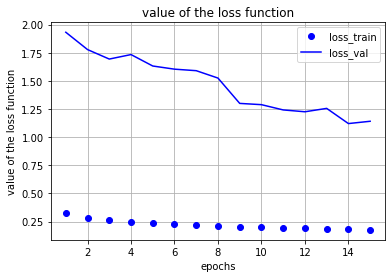

In [19]:
import matplotlib.pyplot as plt
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

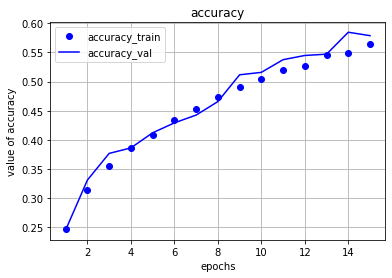

In [21]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

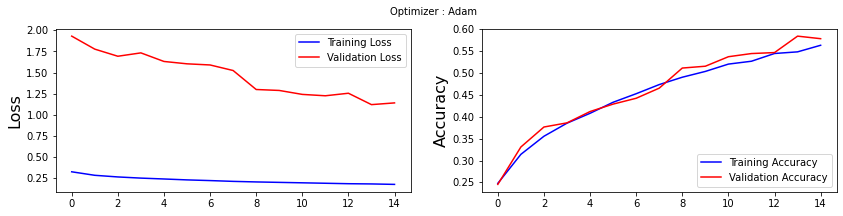

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

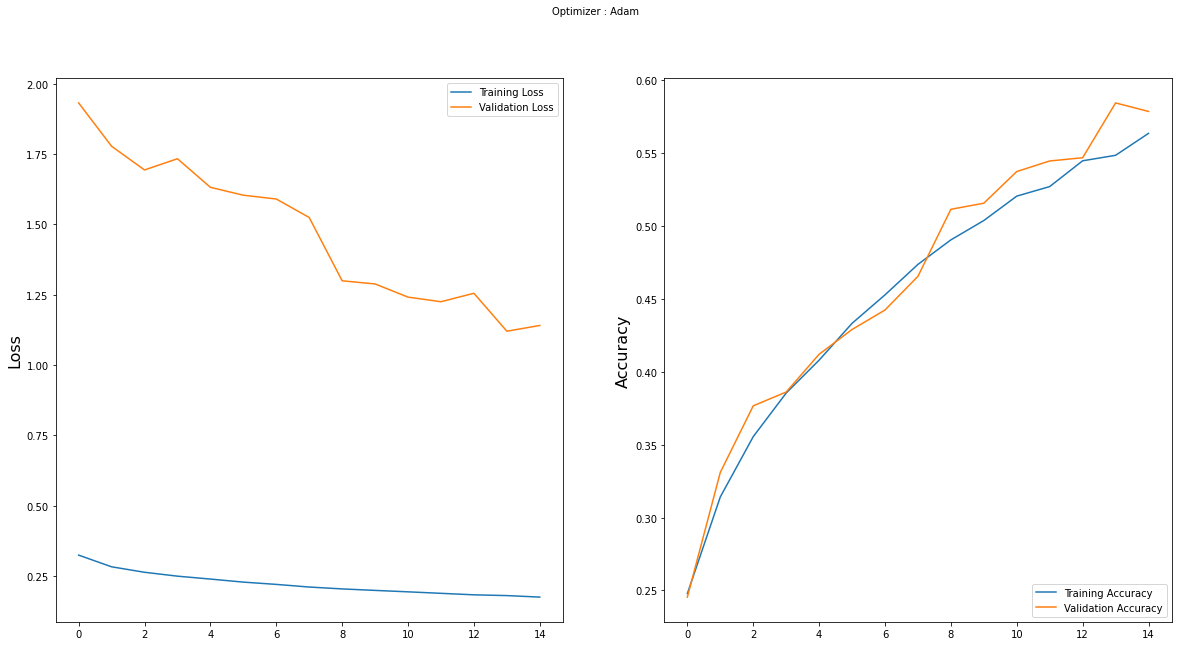

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [28]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()

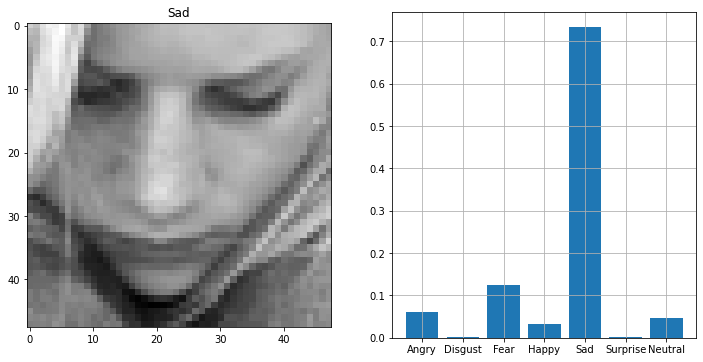

In [29]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 26)


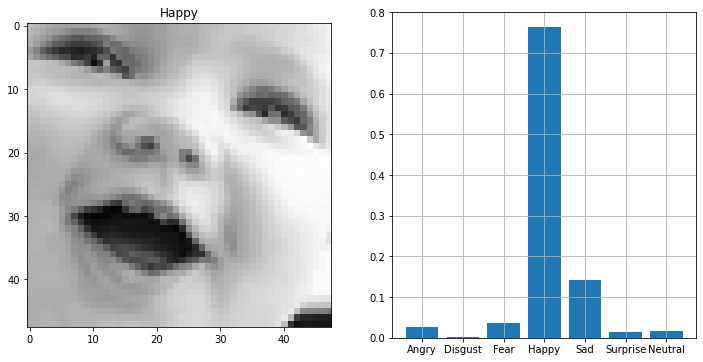

In [30]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 10)


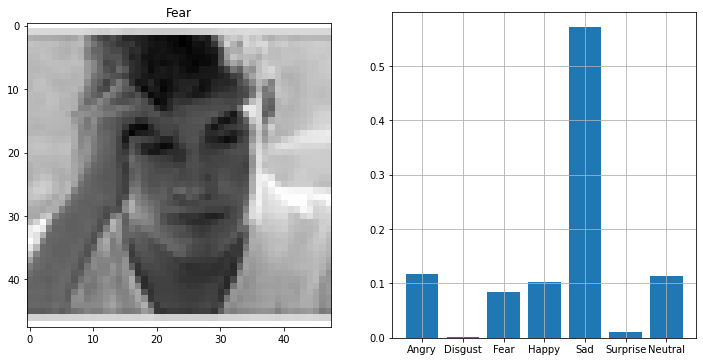

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 8)


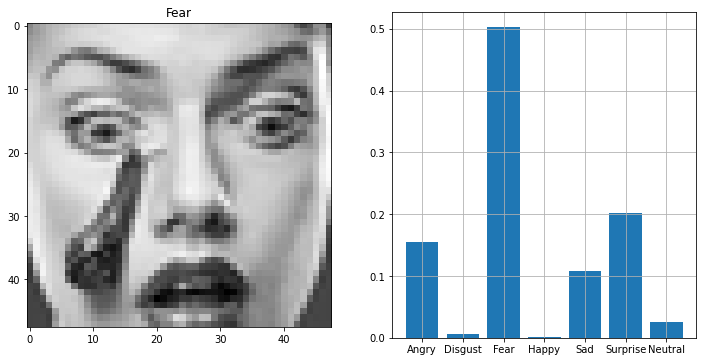

In [32]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 15)


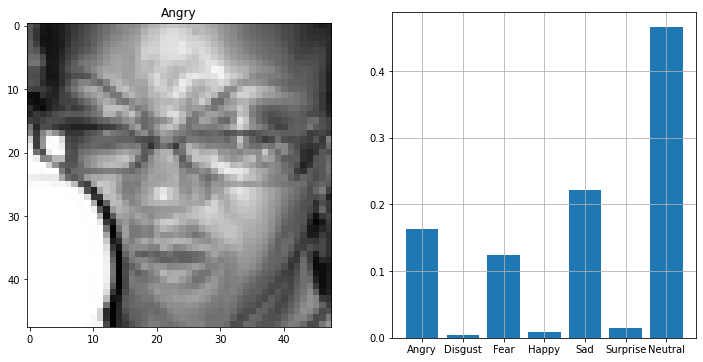

In [33]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 122)


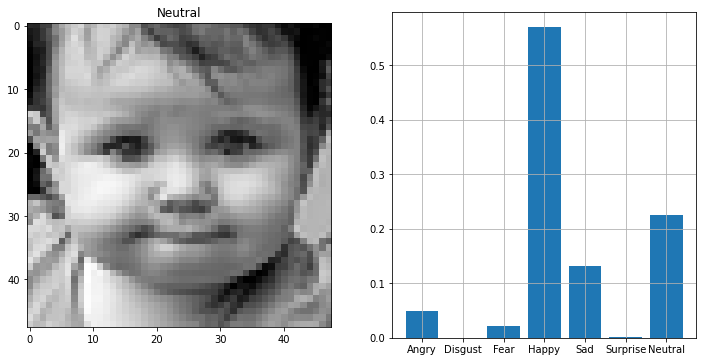

In [34]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 125)


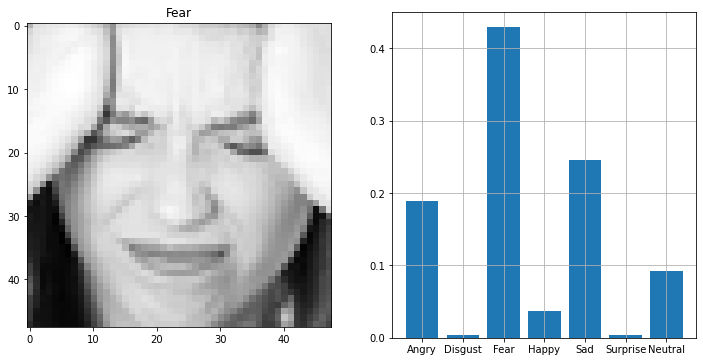

In [35]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 115)


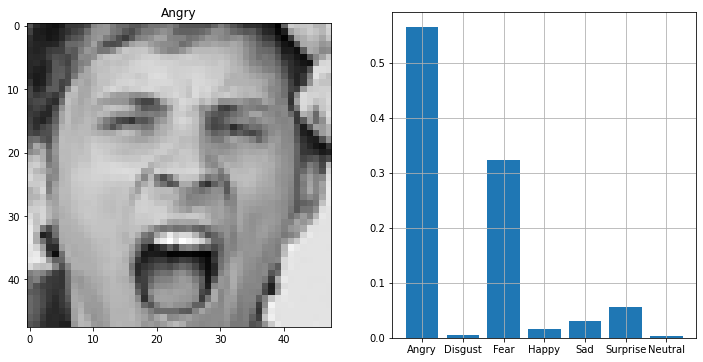

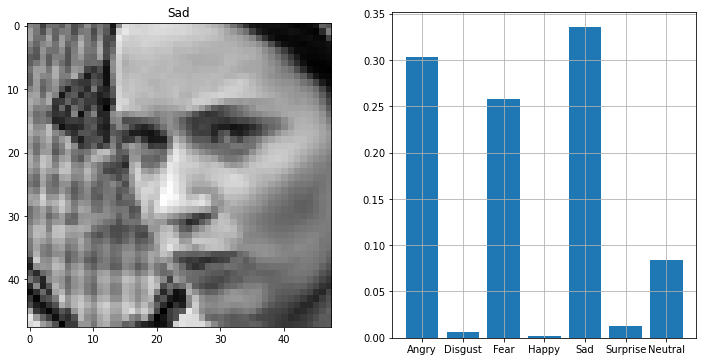

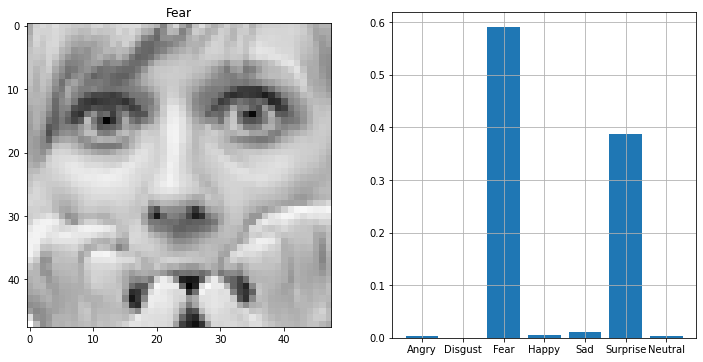

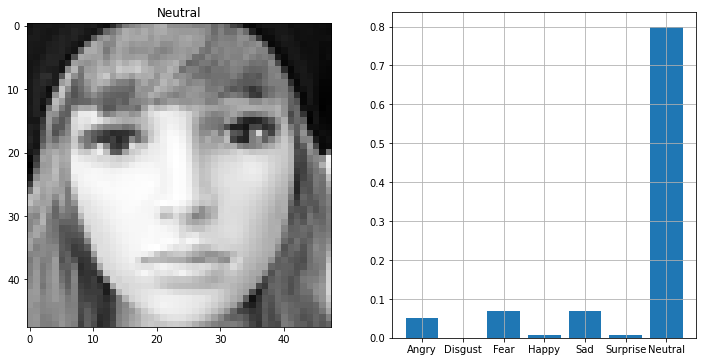

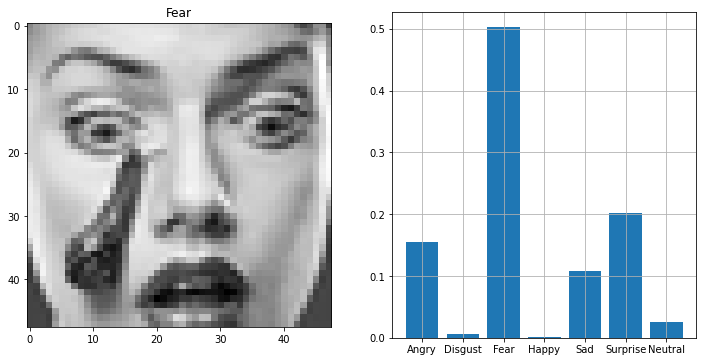

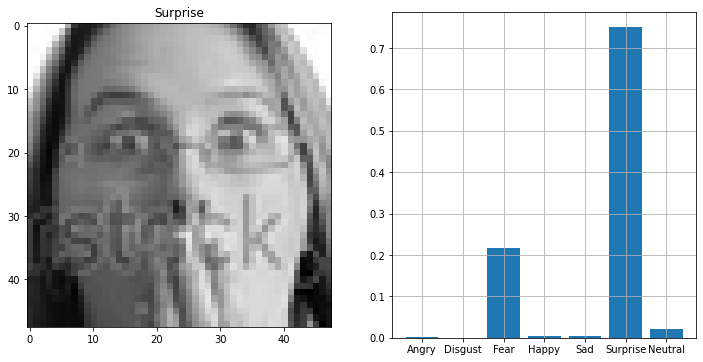

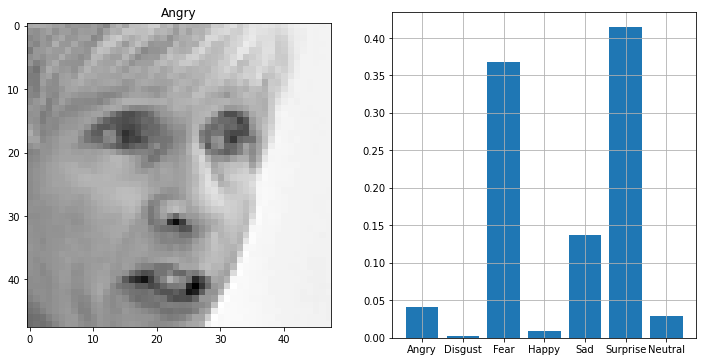

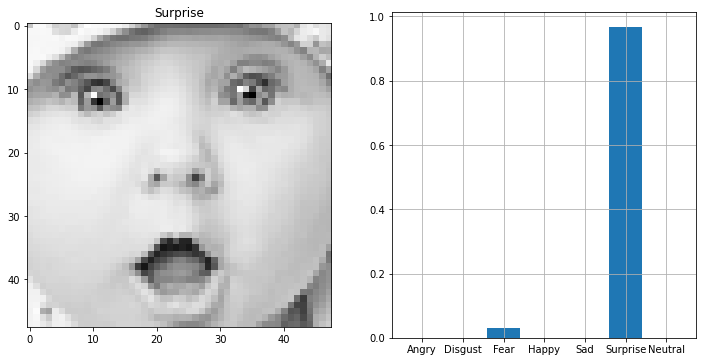

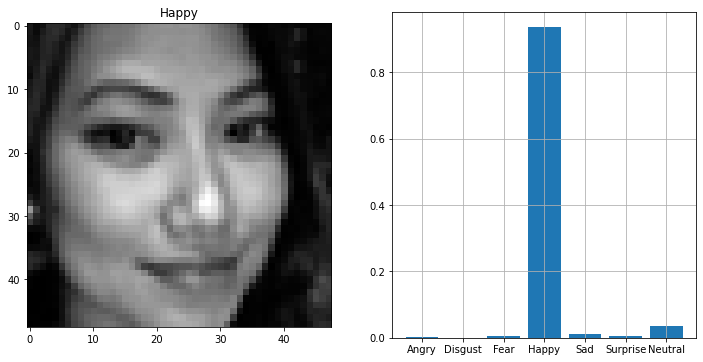

In [38]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 11)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 12)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 13)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 14)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 15)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 16)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 17)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 18)
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 19)

